In [1]:
import numpy as np
import galpynamics
import galpynamics.dynamic_component as dc
import matplotlib.pyplot as plt
from galpynamics.dynamics import galpotential
from scipy import interpolate
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator, MultipleLocator
cm = 'plasma'

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


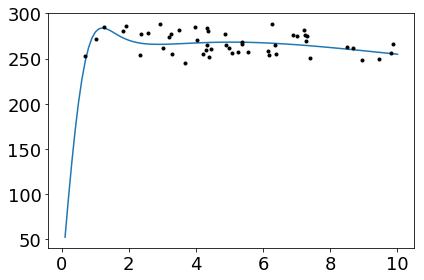

In [2]:
#Generate some data
def rot_curve(distance,Mbulge,Rbulge,Mdisc,Rdisc,Zdisc,Denshalo,Rhalo):
    halo=dc.NFW_halo(d0=Denshalo, rs=Rhalo, mcut=100., e=0.) #Halo
    bulge=dc.valy_halo(mass=Mbulge, rb=Rbulge, mcut=3., e=0.) #Bulge
    disc=dc.Exponential_disc.thick(sigma0=Mdisc/(2*np.pi*Rdisc**2.),Rd=Rdisc, zd=Zdisc, flaw='constant', zlaw='sech2', Rcut=19., zcut=10.,check_thin=False)
    MW=galpotential(dynamic_components=(halo,disc,bulge))
    vgrid=MW.vcirc(distance,show_comp=True,nproc=1)
    return vgrid[:,-1]



dist=np.linspace(0.1,10,100)
np.random.seed(123)
d_GC = np.random.uniform(0.1,10,50)
v_rot = rot_curve(d_GC,2e10,0.5,5e10,2.5,0.3,3e7,10)
v_obs = np.random.normal(v_rot,10) #dispersion around rotation curve

plt.plot(dist, rot_curve(dist,2e10,0.5,5e10,2.5,0.3,3e7,10))
plt.plot(d_GC, v_obs, 'k.')
plt.show()

In [3]:
#Working with theano variables
import time
import theano.tensor as tt
from theano.compile.ops import as_op

#####THEANO VERSION#####

#Declaring function ready to work with theano variables using the decarator as_op to use as input and output theano variables
@as_op(itypes=[tt.dvector,tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar,], otypes=[tt.dvector])
def rot_curve_theano(distance,Mbulge,Rbulge,Mdisc,Rdisc,Zdisc,Denshalo,Rhalo):
    halo=dc.NFW_halo(d0=Denshalo, rs=Rhalo, mcut=100., e=0.) #Halo
    bulge=dc.valy_halo(mass=Mbulge, rb=Rbulge, mcut=3., e=0.) #Bulge
    disc=dc.Exponential_disc.thick(sigma0=Mdisc/(2*np.pi*Rdisc**2.),Rd=Rdisc, zd=Zdisc, flaw='constant', zlaw='sech2', Rcut=19., zcut=10.,check_thin=False)
    MW=galpotential(dynamic_components=(halo,disc,bulge))
    vgrid=MW.vcirc(distance,show_comp=True,nproc=1)
    return vgrid[:,-1]

#Variables using _shared theano tensor to pass from pure python variables to theano tensors
distance=tt._shared(d_GC)
Mbulge=tt._shared(np.cast['float64'](2.0e10))
Rbulge=tt._shared(np.cast['float64'](0.5))
Dhalo = tt._shared(np.cast['float64'](3e7))
Rhalo = tt._shared(np.cast['float64'](10))
Mdisc = tt._shared(np.cast['float64'](5e10)) 
Rdisc = tt._shared(np.cast['float64'](2.5))
Zdisc = tt._shared(np.cast['float64'](0.3))

#timing
t1=time.time()
v_rot_theano = rot_curve_theano(distance,Mbulge,Rbulge,Mdisc,Rdisc,Zdisc,Dhalo,Rhalo)
t2a=time.time()
v_rot=v_rot_theano.eval()
t2b=time.time()
print('Theano version time (estimating vrot)',t2a-t1)
print('Theano version time (estimating vrot+cast to numpy array)',t2b-t1)


###STANDARD VERSION
#timing
t1=time.time()
v_rot = rot_curve(d_GC,2.0e10,0.5,5e10,2.5,0.3,3e7,10)
t2=time.time()
print('Standard version time (estimating vrot)',t2-t1)

#Comparative plot
plt.scatter(d_GC,v_rot,label='Theano version',c='black',s=50) #THEANO
plt.scatter(d_GC,v_rot,s=5,label='Standard version',c='red') #STANDARD
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'theano'

In [8]:
#PYMC3#
import pymc3 as pm
import corner



RC_model = pm.Model()
with RC_model as model_deterministic: 
    # Priors for unknown model parameters
    Dhalo = pm.Uniform('Dhalo', lower=1e+6,upper=1e+8)
    Rhalo = pm.Uniform('Rhalo', lower=1.,upper=50.)
    Mdisc = pm.Uniform('Mdisc', lower=1e+10,upper=1e+12) #pm.Normal('Mdisc', mu=1e+10, sd=10.)#
    Rdisc = pm.Normal('Rdisc', mu=2.5, sd=0.1)#pm.Uniform('Rdisc', lower=1.,upper=10.)
    Zdisc = pm.Normal('Zdisc', mu=0.3, sd=0.1)#pm.Uniform('Hdisc', lower=0.05,upper=0.5)
    
    #Constant parameters
    distance=tt._shared(d_GC)
    Mbulge=tt._shared(np.cast['float64'](2.0e10))
    Rbulge=tt._shared(np.cast['float64'](0.5))

    # Expected value of outcome (model)
    v_rot = rot_curve_theano(distance,Mbulge,Rbulge,Mdisc,Rdisc,Zdisc,Dhalo,Rhalo)

    # Likelihood (sampling distribution) of observations
    v_fit = pm.Normal('v_fit', mu=v_rot, sd=10, observed=v_obs)

   
with RC_model:
    
    #Number of threads
    nproc=4
    #Number of burn-in samples
    Nburn=10
    # Number of posterios samples
    Npost=10 
    # instantiate sampler
    step = pm.Metropolis()
    # draw  posterior samples
    trace = pm.sample(draws=Npost,step=step,njobs=nproc,tune=Nburn)

  0%|          | 0/20 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '7436' (I am process '7437')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/Giuliano/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
100%|██████████| 20/20 [05:24<00:00, 16.24s/it]


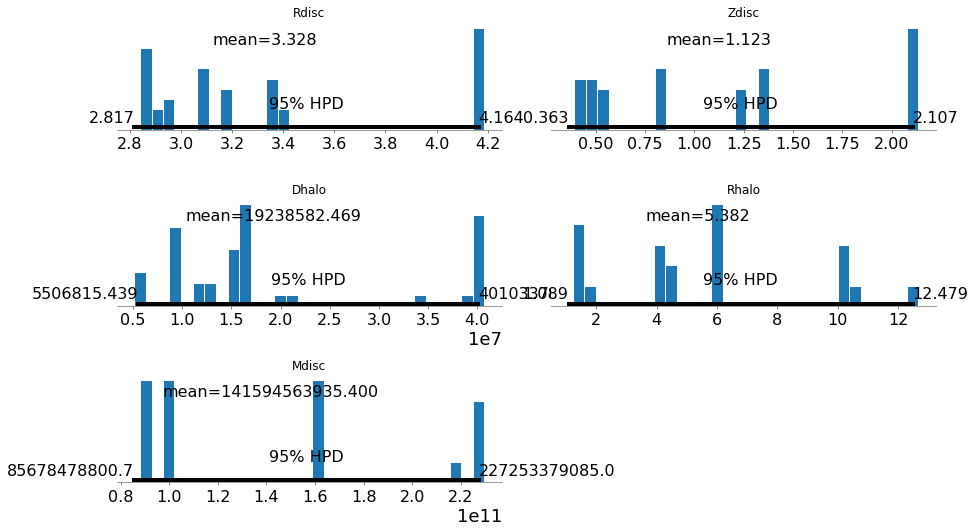

In [12]:
pt=pm.plot_posterior(trace)